In [2]:
import numpy as np
import pandas as pd
import ssl
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import random
import pickle
from pprint import pprint

from sklearn.metrics import hamming_loss, roc_auc_score
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 

from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import wordcloud

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC, NuSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer


import scikitplot as skplt
import matplotlib.pyplot as plt

from keras import optimizers
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

from scipy.special import softmax

ssl._create_default_https_context = ssl._create_unverified_context

Using TensorFlow backend.


In [3]:
def clean_statement(statement):
#     x = re.sub('-', ' ', x)
    statement = re.sub('$', ' ', statement)
    statement = re.sub('[^A-Za-z]+', ' ', statement)
    statement = re.sub('[,|.|?|\n]|\t', '', statement)
    statement = re.sub('n\'t', ' ', statement)
    statement = re.sub('submission|submissions|Submission|submission|th ', '', statement)
    statement = re.sub('one|two|given|need', '', statement)
    
    return statement

In [4]:
def process_problem_statement(q_statement):
    
    q_statement = clean_statement(q_statement)
    
#     q_statement = re.sub('[^A-Za-z]+', ' ', q_statement)
    
    tokens = word_tokenize(q_statement)
    
    stoplist = set(stopwords.words('english'))
    
    word_list = [i for i in q_statement.lower().split() if i not in stoplist]
    
    ps = PorterStemmer()
    
#     word_list = [ps.stem(word) for word in word_list]
    
    q_statement = ' '.join(word_list)
    
#     print(q_statement)
    
    return q_statement

In [5]:
def process_problem_solution(solution):
    
#     solution = clean_statement(solution)
    
    tokens = word_tokenize(solution)
    
    stoplist = set(stopwords.words('english'))
    
    word_list = [i for i in solution.lower().split() if i not in stoplist]
    
#     ps = PorterStemmer()
    
#     word_list = [ps.stem(word) for word in word_list]
    
    solution = ' '.join(word_list)
    
#     print(q_statement)
    
    return solution

In [6]:
def process_tags(tags):
    
    tags = clean_statement(tags)
#     print(tags)
#     print(tag_col)
    tags = tags.strip()
    tags_present = list(re.split(' ',tags))
    
#     stoplist = set(stopwords.words('english'))
#     word_list = [i for i in solution.lower().split() if i not in stoplist]
    
#     tags_set = set(tags_present)
#     tags_diff = tags_set.difference(set(all_tags_list))
    
#     new_set = tags_set.difference(tags_diff)
#     print(new_set)
    return tags_present  

In [7]:
def get_all_distinct_tags(tags_col):
    
    tags_list = []
    t_sets = set(tags_list)
    
    for row in tags_col:
#         for items in row:
#             print(items)
        t_sets = t_sets.union(set(row))
#         print(t_sets)
    tags_list = list(t_sets)
    
#     stoplist = set(stopwords.words('english'))
#     word_list = [i for i in tags_list if i not in stoplist]
    
    return tags_list

In [8]:
def process_problem_Languages(lang_col):
    
    lang_col = clean_statement(lang_col)
    
    return lang_col

In [9]:
global tags_list_codeforces , tags_list_codechef

tags_list_codeforces = ['dsu', 'trees', 'chinese remainder theorem', 'sortings', 'games', 'implementation', 'bitmasks',
              '*special', 'hashing', 'geometry', 'two pointers', 'combinatorics', 'flows', 'strings',
              'probabilities', 'data structures', 'ternary search', 'greedy', 'math', 'matrices',
              'divide and conquer', 'dfs and similar', 'constructive algorithms', 'brute force', 'dp',
              '2-sat', 'graph matchings', 'binary search', 'number theory', 'graphs', 'fft', 'shortest paths',
              'schedules', 'meet-in-the-middle', 'string suffix structures', 'expression parsing']


tags_list_codechef = ['tree', 'binarysearch', 'combinatorial', 'gcd', 'dijkstra','memoization','bipartite','fibonacci','sieve','map',
             'strings','suffix', 'geometry', 'knapsack', 'sorting', 'recursion', 'pointers', 'maxflow','binary', 'fenwick', 'game',
             'constructive','expo', 'graph', 'simulation', 'fft', 'algorithm', 'dfs', 'heap','bitmasking', 'hashing', 'basic', 
             'combinatorics', 'graphs', 'greedy', 'interactive', 'bfs', 'implementation', 'advanced', 'number', 'parsing', 'search',
             'prime', 'dynamic', 'deque', 'sets',  'disjoint','bitwise', 'digraph', 'theory', 'backtracking', 'probability','set', 
             'series', 'matrix', 'divide', 'kruskal','pattern', 'bruteforce','trees','maths','enumeration','counting',
             'regex','tries', 'algebra', 'matching', 'multiset','euler', 'inversions', 'segment', 'permutation', 'stack', 
             'recurrence', 'dp', 'adhoc']
             

In [10]:
def validate_tags(Y):
    new_tags_list = []
    for tags in Y:
        i = 0
        while i<len(tags):
            if tags[i] not in tags_list_codechef:
                tags.remove(tags[i])
                continue
            i += 1
        new_tags_list.append(tags)
    return new_tags_list

In [11]:
def plot_class_distribution(Y,classes):
    
    count_list = [0]*Y.shape[1]
    
    for index in range(Y.shape[1]):
        
        count_list[index] = np.sum(Y[:,index])/Y.shape[0]
    
    plt.figure(figsize=(10, 15), dpi=100)
    
    plt.barh(classes,count_list, align='center', alpha=0.5)
#     plt.bar(np.arange(Y.shape[1]),count_list, align='center', alpha=0.5)
#     plt.plot(np.arange(Y.shape[1]),count_list)
    plt.show()

In [12]:
def oversample_train_data(X_train,Y_train):
    
    global X, Y, mlb, distinct_tags
    
    X_train = pd.DataFrame(X_train).values
    
    XY = np.column_stack((X_train,Y_train))
    
    labels = []
    data_to_repeat_index = [1]*Y_train.shape[0]
    
    for index in range(Y_train.shape[1]):
        if np.sum(Y_train[:,index])/Y_train.shape[0] < 0.005:
            labels.append(index)
    
    print(labels)
    
    for index in range(Y_train.shape[0]):
        for label in labels:
            if Y_train[index][label] == 1:
                data_to_repeat_index[index] = 50
    

    XY = np.repeat(XY, repeats = data_to_repeat_index, axis=0)
    
    X_train = XY[:,0]
    Y_train = XY[:,1:]
        
#     Ytrain = mlb.inverse_transform(Y_train)
    
#     print(Ytrain)
    
    X_train = pd.Series(X_train)
    X_train = X_train.astype(str)
    Y_train = Y_train.astype('int') 
    return X_train,Y_train

In [13]:
def reduce_sample_imbalance(X_train,Y_train):
    
    global X, Y, mlb, distinct_tags
        
    xtrain_col_index = X_train.shape[1]
    xtrain_row_index = X_train.shape[0]
    
    XY = np.column_stack((X_train,Y_train))
    
    labels = [0]*len(mlb.classes_)
    row_index_to_delete = []
    ratio = []
    
    for index in range(Y_train.shape[1]):
        ratio.append(np.sum(Y_train[:,index])/Y_train.shape[0])
        if np.sum(Y_train[:,index])/Y_train.shape[0] > 0.005:
            
            labels[index] = 1
            
    ratio.sort()

    count_deletions = [0]*len(labels)
    for index in range(len(labels)):
        if labels[index] == 1:

            count_deletions[index] = int(np.sum(Y_train[:,index]) * 0.995)    
    
    for index in range(Y_train.shape[0]):
        flag_to_delete = True
        
        for yindex in range(X_train.shape[1],XY.shape[1]):
            if Y_train[index][yindex-X_train.shape[1]] == 1:
                if labels[yindex-X_train.shape[1]] == 0 or count_deletions[yindex-X_train.shape[1]] <= 0:
                    flag_to_delete = False
                    break
        
        if flag_to_delete:
            row_index_to_delete.append(index)
            for i in range(len(count_deletions)):
                count_deletions[i] -= Y_train[index][i]
    
        if sum(count_deletions) <= 0:
            break;
            
    print(XY.shape)
    XY = np.delete(XY, row_index_to_delete,axis=0)
    print(XY.shape)
    
    ratio = []
    for index in range(X_train.shape[1],XY.shape[1]):
        ratio.append(np.sum(XY[:,index])/XY.shape[0])
    
    plot_class_distribution(XY[:,X_train.shape[1]:],mlb.classes_)
    
    
    data_to_repeat_index = [1]*XY.shape[0]
    labels = [0]*len(mlb.classes_)
    ratio = []
    for index in range(xtrain_col_index,XY.shape[1]):
        ratio.append(np.sum(XY[:,index])/XY.shape[0])
        if np.sum(XY[:,index])/XY.shape[0] < 0.005:
            labels[index-xtrain_col_index] = 1
    

    ratio.sort()
        
    for index in range(XY.shape[0]):
        for yindex in range(X_train.shape[1],XY.shape[1]):
            if XY[index][yindex] == 1 and labels[yindex-X_train.shape[1]] > 0:
                data_to_repeat_index[index] = 200
                labels[yindex-X_train.shape[1]] = -1
    
    print(XY.shape)
    XY = np.repeat(XY, repeats = data_to_repeat_index, axis=0)
    print(XY.shape)
    
    X_train = XY[:,:X_train.shape[1]]
    Y_train = XY[:,X_train.shape[1]:]

    return X_train,Y_train

In [20]:
def process_dataset(X,Y):
    
    tag_percentage = [0]*Y.shape[1]
    y_modified = copy.deepcopy(Y)
    
    for row_index in range(y_modified.shape[0]):
        
        for col_index in range(Y.shape[1]):
            tag_percentage[col_index] = np.sum(y_modified[:,col_index])/y_modified.shape[0]
            
        min_val = min(tag_percentage)
        
        for i in range(len(tag_percentage)):
            
            if y_modified[row_index,i] == 1:
                tag_percentage[i] = int(tag_percentage[i]/min_val)
            else:
                tag_percentage[i] = float("inf")
            
        min_val = min(tag_percentage)
    
        for col_index in range(y_modified.shape[1]):
            if tag_percentage[col_index]/min_val > 1:
                y_modified[row_index,col_index] = 0
        
    for col_index in range(y_modified.shape[1]):
        tag_percentage[col_index] = np.sum(y_modified[:,col_index])/y_modified.shape[0]
    
    tag_percentage.sort()
    print(tag_percentage)
    
    return X,y_modified

In [26]:
def data_preprocessing():
    
    global X, Y, mlb, distinct_tags
    
    df = pd.read_csv("codechef_questions_v8.csv")
    print(df.columns)
    print(df.shape)   
    
    X = copy.deepcopy(df["Solution"]+df["Difficultylevel"])
    Y = [process_tags(x) for x in df["tags"]]
    distinct_tags = get_all_distinct_tags(Y)
    
    mlb = MultiLabelBinarizer()
    Y = mlb.fit_transform(Y)
    print(mlb.classes_)

#     X,Y = process_dataset(X,Y)
    plot_class_distribution(Y,mlb.classes_)

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'Difficultylevel', 'Problem Statement', 'Solution', 'tags'],
      dtype='object')
(28591, 8)
['adhoc' 'advanced' 'algebra' 'algorithm' 'backtracking' 'basic' 'bfs'
 'binary' 'binarysearch' 'bipartite' 'bitmasking' 'bitwise' 'bruteforce'
 'combinatorial' 'combinatorics' 'constructive' 'counting' 'deque' 'dfs'
 'digraph' 'dijkstra' 'disjoint' 'divide' 'dp' 'dynamic' 'enumeration'
 'euler' 'expo' 'fenwick' 'fft' 'fibonacci' 'game' 'gcd' 'geometry'
 'graph' 'graphs' 'greedy' 'hashing' 'heap' 'implementation' 'interactive'
 'inversions' 'knapsack' 'kruskal' 'map' 'matching' 'maths' 'matrix'
 'maxflow' 'memoization' 'multiset' 'number' 'parsing' 'pattern'
 'permutation' 'pointers' 'prime' 'probability' 'recurrence' 'recursion'
 'regex' 'search' 'segment' 'series' 'set' 'sets' 'sieve' 'simulation'
 'sorting' 'stack' 'strings' 'suffix' 'theory' 'tree' 'trees' 'tries']


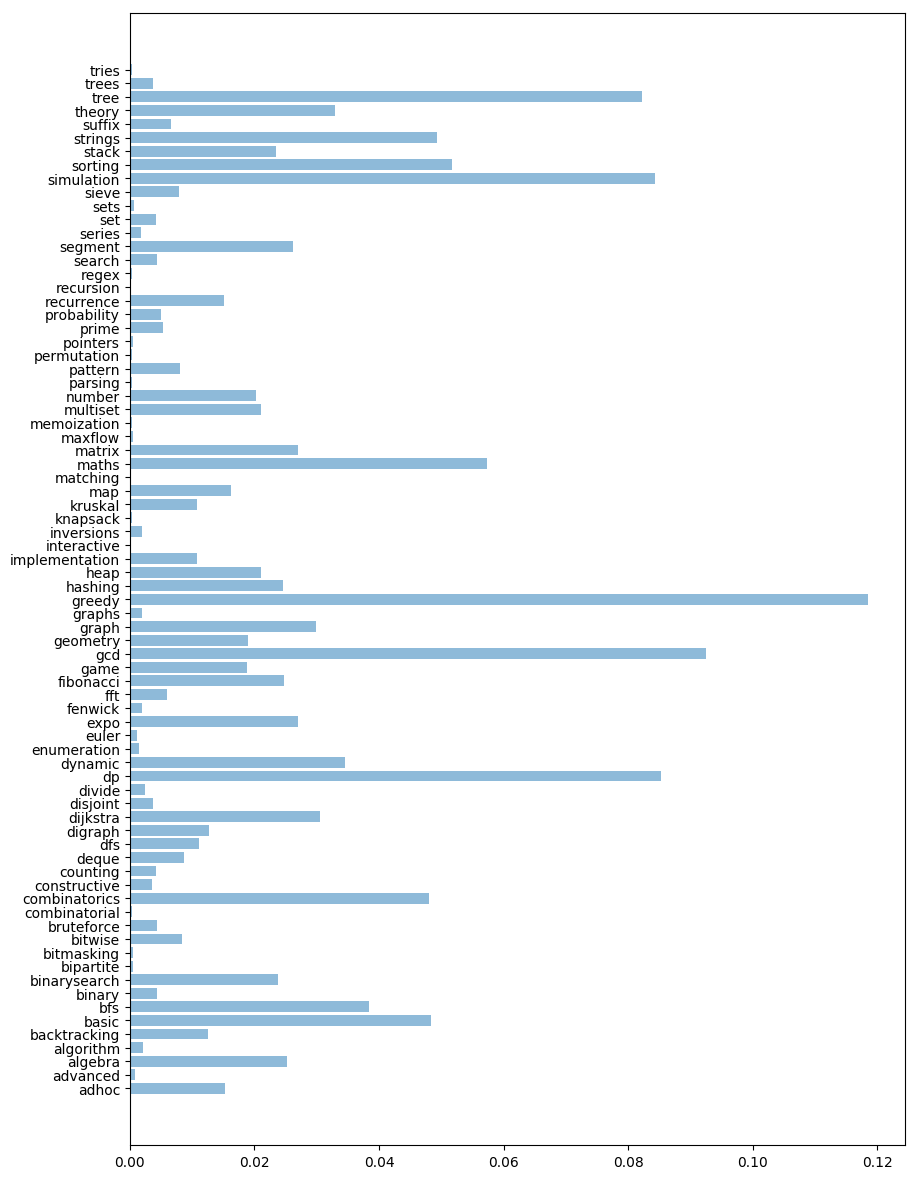

In [27]:
data_preprocessing()

In [31]:
global X, Y, mlb, distinct_tags
print(type(X),type(Y),type(mlb))


n_most_common_words = 2000
max_len = 500

tokenizer = Tokenizer(num_words=n_most_common_words, filters=';/@?`~', lower=False)
tokenizer.fit_on_texts(X.values)
sequences = tokenizer.texts_to_sequences(X.values)
word_index = tokenizer.word_index
_X = pad_sequences(sequences, maxlen=max_len)


X_train, X_validation, Y_train, Y_validation = train_test_split(_X, Y, test_size = 0.2, random_state = 0)

plot_class_distribution(Y_train,mlb.classes_)
X_train,Y_train = reduce_sample_imbalance(X_train,Y_train)
# X_train,Y_train = oversample_train_data(X_train,Y_train)
plot_class_distribution(Y_train,mlb.classes_)
# # print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
plot_classs_distribution(Y_validation,mlb.classes_)


epochs = 1
emb_dim = 300
batch_size = 250

print((X_train.shape, Y_train.shape, X_validation.shape, Y_validation.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim))
# , recurrent_dropout=0.3
model.add(LSTM(128, dropout=0.1))
model.add(Dense(76, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])
print(model.summary())

<class 'pandas.core.series.Series'> <class 'numpy.ndarray'> <class 'sklearn.preprocessing.label.MultiLabelBinarizer'>
((22872, 500), (22872, 76), (5719, 500), (5719, 76))
Train on 18297 samples, validate on 4575 samples
Epoch 1/1
18297/18297 [==============================] - 225s 12ms/step - loss: 0.0805 - binary_accuracy: 0.9817 - val_loss: 0.0751 - val_binary_accuracy: 0.9815
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         600000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_3 (Dense)              (None, 76)                9804      
Total params: 829,452
Trainable params: 829,452
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
_y_predicted = model.predict(X_validation)

In [30]:
global X, Y, mlb, distinct_tags

# y_predicted = copy.deepcopy(_y_predicted)
# m = []
# for row in y_predicted:
#     m.append(row)

# final_prediction = []

# for row in m:
#     temp = []
#     val = np.sort(row)[-3]
#     for item in row:
#         if item < val:
#             temp.append(0)
#         else:
#             temp.append(1)
#     final_prediction.append(temp)


# final_prediction = np.array(final_prediction)

y_predicted = copy.deepcopy(_y_predicted)
predicted = [([0]*Y_validation.shape[1])]*Y_validation.shape[0]

cnt = 0
for row in y_predicted:
    count_tags = int(np.sum(Y_validation[cnt,:]))
    index_list = []

    predicted[cnt] = [0]*Y_validation.shape[1]
    
    for i in range(count_tags):
        max_val = -1
        max_index = -1
        row = list(row)
        for j in range(len(row)):
            if row[j] > max_val:

                max_index = j
                max_val = row[j]
        
        if max_val != -1 and max_index != -1:

            index_list.append(max_index)
            predicted[cnt][max_index] = 1
            row[max_index] = -10
    cnt += 1
    

final_prediction = predicted
final_prediction = np.array(final_prediction,dtype=np.int64)
Y_validation[int(Y_validation.shape[0]/2),:] =  1

        
print("Hamming_loss: ",hamming_loss(Y_validation,final_prediction))
print('Test recall_score is {}'.format(recall_score(Y_validation, final_prediction,average = 'weighted')))
print('Test precision_score is {}'.format(precision_score(Y_validation, final_prediction,average = 'weighted')))
print('Test f1_score is {}'.format(f1_score(Y_validation, final_prediction,average = 'weighted')))
print("roc_auc_score: ",roc_auc_score(Y_validation,final_prediction,average = 'weighted'))

all_labels = mlb.inverse_transform(final_prediction)
y_labels = mlb.inverse_transform(Y_validation)

for item, labels in zip(y_labels, all_labels):
        print('{0} => {1}'.format(item, ', '.join(labels)))
        
        
################################################################################

metrics_list = []
recall_list = []
precision_list = []
roc_auc_list = []
f1_score_list = []

classes_list = mlb.classes_
    
for col_index in range(Y_validation.shape[1]):
    recall_list.append(recall_score(Y_validation[:,col_index],final_prediction[:,col_index]))
    
for col_index in range(Y_validation.shape[1]):
    precision_list.append(precision_score(Y_validation[:,col_index],final_prediction[:,col_index]))
    
for col_index in range(Y_validation.shape[1]):
    f1_score_list.append(f1_score(Y_validation[:,col_index],final_prediction[:,col_index]))
    
for col_index in range(Y_validation.shape[1]):
    roc_auc_list.append(roc_auc_score(Y_validation[:,col_index],final_prediction[:,col_index]))

metrics_list = [mlb,classes_list,recall_list,precision_list,f1_score_list,roc_auc_list,Y_validation,final_prediction]

with open('LSTM_Codechef', 'wb') as fp:
    pickle.dump(metrics_list, fp)

################################################################################


Hamming_loss:  0.032401229511968416
Test recall_score is 0.13628599316739873
Test precision_score is 0.034009075672246175
Test f1_score is 0.05092539350923068
roc_auc_score:  0.5182189517291518
('algebra',) => greedy
('bfs', 'dijkstra') => gcd, greedy
('bfs', 'dijkstra') => gcd, greedy
('gcd',) => greedy
('strings',) => simulation
('dynamic',) => greedy
('simulation',) => simulation
('game', 'theory') => dp, greedy
('expo', 'matrix', 'recurrence') => gcd, greedy, tree
('bfs', 'dijkstra') => gcd, greedy
('maths',) => greedy
('combinatorics',) => greedy
('binarysearch', 'fibonacci', 'hashing') => gcd, greedy, tree
('dp',) => greedy
('gcd',) => greedy
('segment', 'tree') => dp, greedy
('basic', 'pattern', 'stack') => gcd, greedy, tree
('simulation', 'sorting') => gcd, greedy
('dp',) => greedy
('game', 'theory') => dp, greedy
('game',) => greedy
('bfs', 'dijkstra') => gcd, greedy
('greedy',) => greedy
('backtracking',) => greedy
('greedy',) => greedy
('greedy',) => greedy
('kruskal',) => g

/home/prakashjha/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/prakashjha/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('kruskal',) => greedy
('greedy',) => greedy
('simulation',) => simulation
('gcd',) => greedy
('gcd',) => greedy
('simulation',) => simulation
('strings',) => simulation
('simulation',) => simulation
('strings',) => simulation
('map', 'sorting') => gcd, greedy
('dp',) => greedy
('dynamic',) => greedy
('basic',) => greedy
('dp',) => greedy
('maths',) => greedy
('fenwick', 'inversions') => dp, greedy
('simulation',) => simulation
('strings',) => simulation
('map', 'sorting') => gcd, greedy
('suffix',) => greedy
('basic', 'pattern', 'stack') => gcd, greedy, tree
('expo', 'maths', 'matrix') => gcd, greedy, tree
('gcd',) => greedy
('strings',) => simulation
('stack',) => greedy
('stack',) => greedy
('greedy', 'heap', 'multiset') => dp, greedy, simulation
('simulation',) => simulation
('divide', 'sets') => greedy, simulation
('algebra',) => greedy
('greedy', 'heap', 'multiset') => dp, greedy, simulation
('bruteforce',) => greedy
('basic',) => greedy
('binarysearch', 'fibonacci', 'hashing') =

/home/prakashjha/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/prakashjha/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
